## Power of batch normailzation

#### Environment

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
import os
import time

from typing import Iterable, Tuple
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

#### Architecture 

* LeNet without batch normalization

In [2]:
class LeNet5(nn.Module):
  def __init__(self):
    super().__init__()
    # Convolution layers
    self._body = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=6, kernel_size=5),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size=2),
    )
    # Fully connected layers
    self._head = nn.Sequential(
        nn.Linear(in_features=16*5*5,out_features=120),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=120,out_features=84),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=84,out_features=10),
    )

  def forward(self,x):
    x = self._body(x)
    x = x.view(x.size()[0],-1)
    x = self._head(x)
    return x

* LeNetBN - add batch normalization

In [3]:
class LeNetBN(nn.Module):
  def __init__(self):
    super().__init__()
    # Convolution layers
    self._body = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=6, kernel_size=5),
        nn.BatchNorm2d(6),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size=2),
    )
    # Fully connected layers
    self._head = nn.Sequential(
        nn.Linear(in_features=16*5*5,out_features=120),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=120,out_features=84),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=84,out_features=10),
    )

  def forward(self,x):
    x = self._body(x)
    x = x.view(x.size()[0],-1)
    x = self._head(x)
    return x

In [4]:
lenet_model = LeNet5()
print(lenet_model)
lenetBN_model = LeNetBN()
print(lenetBN_model)

LeNet5(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)
LeNetBN(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): Ba

#### Prepare data

In [5]:
def get_data(batch_size, data_root='data', num_workers=1):
    
    train_test_transforms = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.2860, ), (0.3530, ))
    ])
    
    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=True, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=False, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

#### Configuration & setup

In [6]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 0
    cudnn_benchmark_enabled: bool = True 
    cudnn_deterministic: bool = True 
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32 
    epochs_count: int = 20  
    learning_rate: float = 0.01  
    log_interval: int = 100  
    test_interval: int = 1  
    data_root: str = "data"  
    num_workers: int = 10  
    device: str = 'cuda'  
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic
    

#### Training & Validation

In [15]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int) -> Tuple[float, float]:
    
    # change model in training mode
    model.train()
    

    batch_loss = np.array([])
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        indx_target = target.clone()
        data = data.to(train_config.device)
        target = target.to(train_config.device)

        optimizer.zero_grad()

        output = model(data)
        
        loss = F.cross_entropy(output, target)
        
        loss.backward()
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        prob = F.softmax(output, dim=1)

        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
            print(
                'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
                )
            )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

* Validation process

In [16]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,) -> Tuple[float, float]:
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    
    # turn off gradient-computation
    with torch.no_grad():
        
        for data, target in test_loader:
            indx_target = target.clone()
            data = data.to(train_config.device)

            target = target.to(train_config.device)

            output = model(data)
            test_loss += F.cross_entropy(output, target).item()
            prob = F.softmax(output, dim=1)
            pred = prob.data.max(dim=1)[1] 

            count_corect_predictions += pred.cpu().eq(indx_target).sum()

        test_loss = test_loss / len(test_loader)  

        accuracy = 100. * count_corect_predictions / len(test_loader.dataset)

        print(
            '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
            )
        )
    return test_loss, accuracy/100.0

#### Main processor

In [17]:
def main(model, system_configuration=SystemConfiguration(), training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)


    batch_size_to_set = training_configuration.batch_size
    num_workers_to_set = training_configuration.num_workers
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, else lower batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2
        epoch_num_to_set = 5

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        epochs_count=epoch_num_to_set,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )

        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=training_configuration.learning_rate
    )

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epoch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # training time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc        

In [18]:
model = LeNet5()
modelBN = LeNetBN() 

model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main(model=model)

modelBN, epoch_train_loss_bn, epoch_train_acc_bn, epoch_test_loss_bn, epoch_test_acc_bn = main(model=modelBN)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Train Epoch: 0 [1600/60000] Loss: 2.263459 Acc: 0.2500
Train Epoch: 0 [3200/60000] Loss: 2.245941 Acc: 0.2500
Train Epoch: 0 [4800/60000] Loss: 1.970295 Acc: 0.5625
Train Epoch: 0 [6400/60000] Loss: 1.180133 Acc: 0.3125
Train Epoch: 0 [8000/60000] Loss: 0.796257 Acc: 0.8125
Train Epoch: 0 [9600/60000] Loss: 1.097154 Acc: 0.6250
Train Epoch: 0 [11200/60000] Loss: 0.806502 Acc: 0.8125
Train Epoch: 0 [12800/60000] Loss: 0.996159 Acc: 0.5625
Train Epoch: 0 [14400/60000] Loss: 1.343382 Acc: 0.5625
Train Epoch: 0 [16000/60000] Loss: 1.230062 Acc: 0.4375
Train Epoch: 0 [17600/60000] Loss: 0.711975 Acc: 0.6250
Train Epoch: 0 [19200/60000] Loss: 0.542011 Acc: 0.7500
Train Epoch: 0 [20800/60000] Loss: 0.336731 Acc: 0.8750
Train Epoch: 0 [22400/60000] Loss: 0.587612 Acc: 0.8125
Train Epoch: 0 [24000/60000] Loss: 0.631632 Acc: 0.6250
Train Epoch: 0 [25600/60000] Loss: 0.527126 Acc: 0.8125
Train Epoch: 0 [27200/600

#### Show result

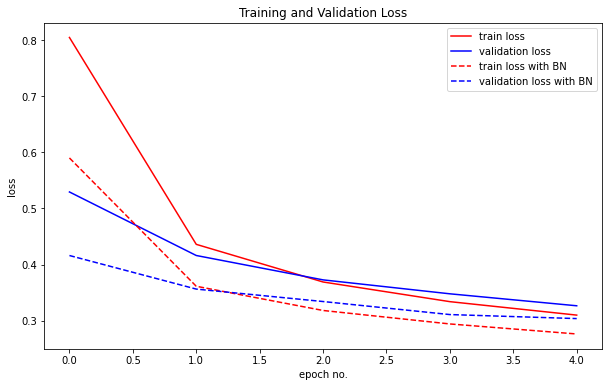

In [19]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_loss, 'r', label="train loss")
plt.plot(x, epoch_test_loss, 'b', label="validation loss")

plt.plot(x, epoch_train_loss_bn, 'r--', label="train loss with BN")
plt.plot(x, epoch_test_loss_bn, 'b--',label="validation loss with BN")

plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
import torchvision
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=train_transform)

print(train_set.data.float().mean()/255)
print(train_set.data.float().std()/255)

tensor(0.2860)
tensor(0.3530)
